In [1]:
import os
from typing import Literal

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from einops import parse_shape, rearrange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import *
import lightgbm as lgb
import xgboost as xgb
import catboost as catb

In [3]:
def generate_data(csv_path, label, ratio=0.85, scaler="minmax", train_lookback=1, test_lookback=1):
    dataset = pd.read_csv(csv_path)
    dataset.set_index("datetime", inplace=True)
    label_index = dataset.columns.values.tolist().index(label)

    train, test = train_test_split(dataset, train_size=ratio, shuffle=False)
    # train.shape, test.shape

    train = train.values
    test = test.values

    train_X = []
    train_y = []

    for i in range(train_lookback, len(train)):
        train_X.append(train[i - train_lookback : i, :])
        train_y.append(train[i, label_index])
    train_X = np.array(train_X)
    train_y = np.expand_dims(np.array(train_y), axis=-1)

    test_X = []
    test_y = []

    for i in range(test_lookback, len(test)):
        test_X.append(test[i - test_lookback : i, :])
        test_y.append(test[i, label_index])
    test_X = np.array(test_X)
    test_y = np.expand_dims(np.array(test_y), axis=-1)
    # train_X.shape,train_y.shape,test_X.shape,test_y.shape

    if scaler == "zscore":
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif scaler == "minmax":
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()

    x_shape = parse_shape(train_X, "N L C")
    train_X = X_scaler.fit_transform(rearrange(train_X, "N L C -> (N L) C"))
    train_X = rearrange(train_X, "(N L) C -> N L C", **x_shape)

    x_shape = parse_shape(test_X, "N L C")
    test_X = X_scaler.transform(rearrange(test_X, "N L C -> (N L) C"))
    test_X = rearrange(test_X, "(N L) C -> N L C", **x_shape)

    train_y = y_scaler.fit_transform(train_y)
    test_y = y_scaler.transform(test_y)

    train_X.shape, train_y.shape, test_X.shape, test_y.shape

    return train_X.squeeze(axis=1), train_y.squeeze(axis=1), test_X.squeeze(axis=1), test_y.squeeze(axis=1), X_scaler, y_scaler

In [4]:
label = {"adjClose": "Adj_Close", "Delta": "Residual"}
ratio = 0.85
repeat = 5
scaler = "minmax"
# scaler = "zscore"
n_estimators = 500
csv_path = {"Basic": "data/aapl_qlib.csv", "Feat_ENG": "data/feat_eng_raw.csv", "Feat_ENG_sel": "data/feat_eng_filtered.csv"}

result = {}
for k in label.keys():
    result[k] = {}
    for k2 in csv_path.keys():
        result[k][k2] = {}
result

{'adjClose': {'Basic': {}, 'Feat_ENG': {}, 'Feat_ENG_sel': {}},
 'Delta': {'Basic': {}, 'Feat_ENG': {}, 'Feat_ENG_sel': {}}}

In [5]:
for l_name, _label in label.items():
    for d_name, _csv in csv_path.items():
        train_X, train_y, test_X, test_y, X_scaler, y_scaler = generate_data(_csv, _label, scaler=scaler)
        lgbr_pred = []
        xgbr_pred = []
        xgbrf_pred = []
        catbr_pred = []
        for _ in range(repeat):
            lgbr = lgb.LGBMRegressor(n_estimators=n_estimators, device="cuda")
            lgbr.fit(train_X, train_y)
            tmp_res = lgbr.predict(test_X)
            lgbr_pred.append(np.expand_dims(tmp_res, axis=-1))

            xgbr = xgb.XGBRegressor(n_estimators=n_estimators, device="cuda")
            xgbr.fit(train_X, train_y)
            tmp_res = xgbr.predict(test_X)
            xgbr_pred.append(np.expand_dims(tmp_res, axis=-1))

            xgbrf = xgb.XGBRFRegressor(n_estimators=n_estimators, device="cuda")
            xgbrf.fit(train_X, train_y)
            tmp_res = xgbrf.predict(test_X)
            xgbrf_pred.append(np.expand_dims(tmp_res, axis=-1))

            catbr = catb.CatBoostRegressor(n_estimators=n_estimators, devices="cuda")
            catbr.fit(train_X, train_y)
            tmp_res = catbr.predict(test_X)
            catbr_pred.append(np.expand_dims(tmp_res, axis=-1))

            del lgbr, xgbr, xgbrf, catbr
        result[l_name][d_name]["LGBMRegressor"] = np.array(lgbr_pred).mean(0).reshape(-1, 1)
        result[l_name][d_name]["XGBRegressor"] = np.array(xgbr_pred).mean(0).reshape(-1, 1)
        result[l_name][d_name]["XGBRFRegressor"] = np.array(xgbrf_pred).mean(0).reshape(-1, 1)
        result[l_name][d_name]["CatBoostRegressor"] = np.array(catbr_pred).mean(0).reshape(-1, 1)

[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 4917, number of used features: 8
[LightGBM] [Info] Start training from score 0.223936


/home/ziyang/miniconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:39:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Learning rate set to 0.092514
0:	learn: 0.2311672	total: 47ms	remaining: 23.5s
1:	learn: 0.2107360	total: 47.7ms	remaining: 11.9s
2:	learn: 0.1921593	total: 48.3ms	remaining: 8s
3:	learn: 0.1752173	total: 48.9ms	remaining: 6.06s
4:	learn: 0.1599611	total: 49.5ms	remaining: 4.9s
5:	learn: 0.1457643	total: 50.2ms	remaining: 4.13s
6:	learn: 0.1330201	total: 50.8ms	remaining: 3.58s
7:	learn: 0.1216022	total: 51.5ms	remaining: 3.17s
8:	learn: 0.1109659	total: 52.1ms	remaining: 2.84s
9:	learn: 0.1012468	total: 52.7ms	remaining: 2.58s
10:	learn: 0.0922880	total: 53.3ms	remaining: 2.37s
11:	learn: 0.0843834	total: 53.9ms	remaining: 2.19s
12:	learn: 0.0771254	total: 54.5ms	remaining: 2.04s
13:	learn: 0.0705775	total: 55.2ms	remaining: 1.91s
14:	learn: 0.0645478	total: 55.8ms	remaining: 1.8s
15:	learn: 0.0590464	total: 56.4ms	remaining: 1.71s
16:	learn: 0.0541510	total: 57.1ms	remaining: 1.62s
17:	learn: 0.0495397	total: 57.8ms	remaining: 1.55s
18:	learn: 0.0453018	total: 58.4ms	remaining: 1.48s

In [6]:
result_df = pd.DataFrame.from_dict({(i, j): result[i][j] for i in result.keys() for j in result[i].keys()}, orient="index")

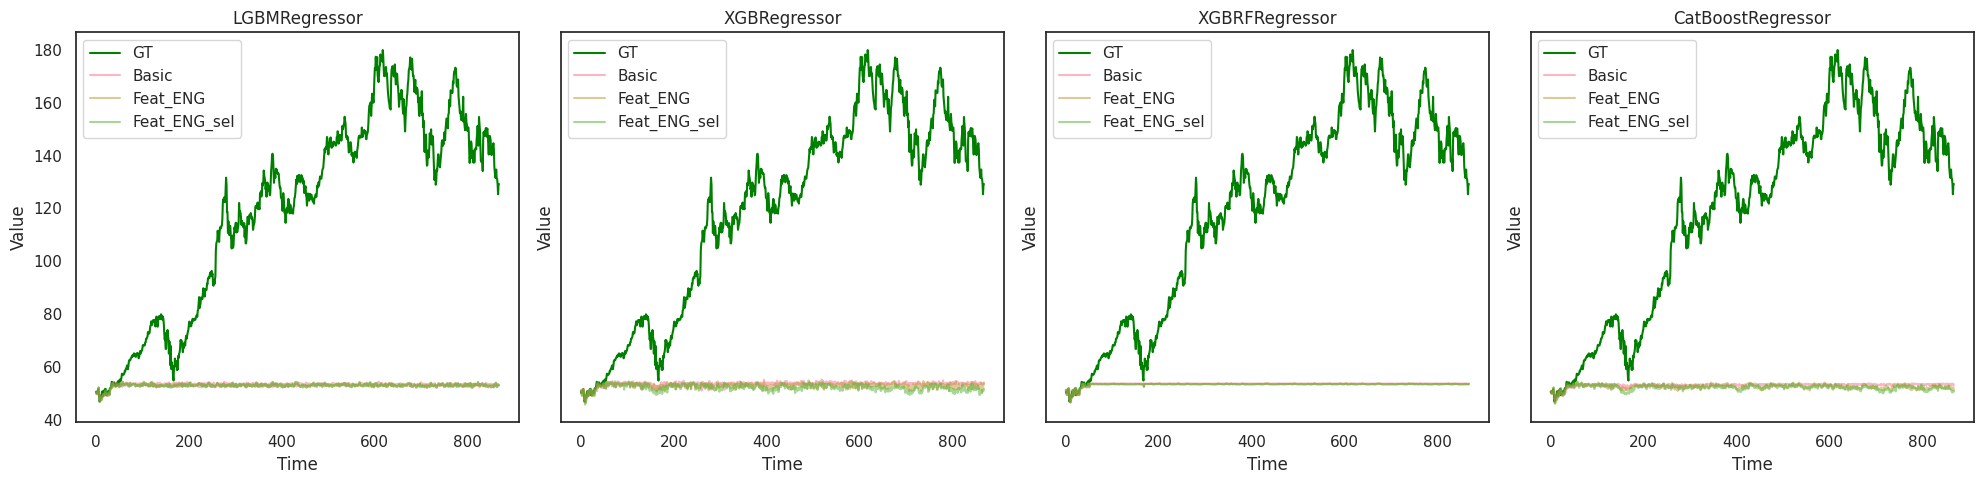

In [49]:
_, _, _, test_y, _, y_scaler = generate_data(list(csv_path.values())[0], "Adj_Close", scaler=scaler)
close_df = result_df.loc["adjClose"]
gt = np.expand_dims(test_y, axis=-1)

sns.set(style="white")
sns.set_palette("husl")

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

for idx, (columnName, columnData) in enumerate(close_df.items()):
    ax[idx].plot(y_scaler.inverse_transform(gt), label="GT", color="green")
    for _, (name, value) in enumerate(columnData.items()):
        ax[idx].plot(y_scaler.inverse_transform(value), label=name, alpha=0.5)
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Value")
    ax[idx].set_title(columnName)
    ax[idx].legend()

plt.tight_layout()
plt.show()

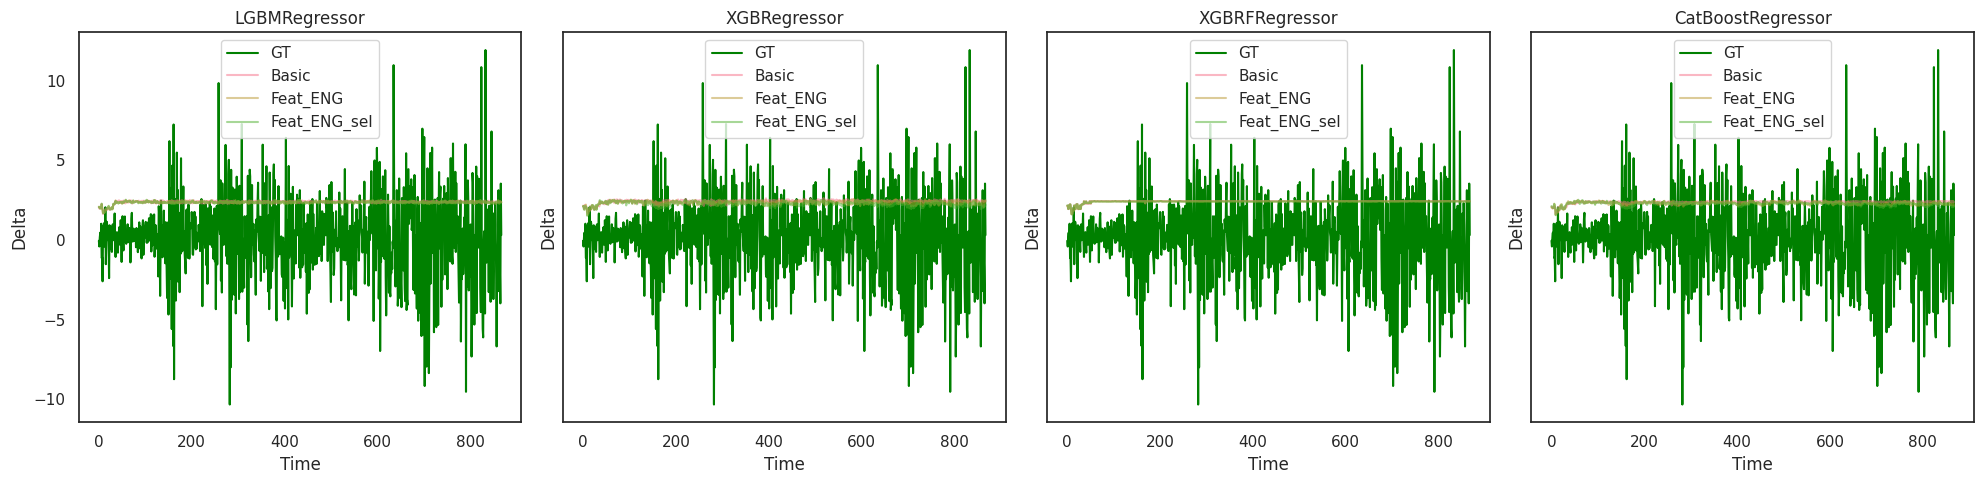

In [51]:
_, _, _, test_y, _, y_scaler = generate_data(list(csv_path.values())[0], "Residual", scaler=scaler)
Delta_df = result_df.loc["Delta"]
gt = np.expand_dims(test_y, axis=-1)

sns.set(style="white")
sns.set_palette("husl")

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

for idx, (columnName, columnData) in enumerate(close_df.items()):
    ax[idx].plot(y_scaler.inverse_transform(gt), label="GT", color="green")
    for _, (name, value) in enumerate(columnData.items()):
        ax[idx].plot(y_scaler.inverse_transform(value), label=name, alpha=0.5)
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Delta")
    ax[idx].set_title(columnName)
    ax[idx].legend()

plt.tight_layout()
plt.show()